# California: ARIMA Time-Series Modeling Notebook 

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

# Read in data

In [2]:
# df = pd.read_csv('../../COVID-19_Nursing_Home_Dataset.csv')

## Split data

Due to size of data file, split data by week submitted to get smaller files that are available to upload. 
> This is commented out so that it only runs when needed.

In [3]:
# def split_data(df,dates):
#     for date in dates:    
#         frame = df[df['Week Ending'] == date]
#         reformatted_date = date.replace('/', '-')
#         frame.to_csv(f'../data/{reformatted_date}-data.csv', index = False)

# dates = df['Week Ending'].unique()

# split_data(df, dates)

## Concatenating files

Create a function that can concatenate the each of the csv files into a single data frame.

In [4]:
df_lst = []
for f in os.listdir('../data'):
    temp = pd.read_csv('../data/' + f)
    df_lst.append(temp)
df = pd.concat(df_lst, ignore_index=True)

In [5]:
# determining the number of weeks for which data is available
week_num = len(df['Week Ending'].unique())
print('num weeks:',week_num)

# Dropping rows where no submitted data
df = df[df['Submitted Data'] == 'Y']

# dropping rows that didn't pass quality assurance check
df = df[df['Passed Quality Assurance Check'] == 'Y']


num weeks: 38


In [6]:
# removing nursing homes who have submissions for each week

submission_counts = Counter(df['Federal Provider Number'])
keys = submission_counts.keys()
to_drop = []
for key in keys:
    if submission_counts[key] < week_num:
        to_drop.append(key)
to_keep = keys-to_drop
print('original:',len(keys))
print('to be dropped:',len(to_drop))
print('to keep:',len(to_keep))

original: 16896
to be dropped: 5914
to keep: 10982


In [7]:
# drop rows for nursing homes that don't meet the criteria fewer entries
df = df[df['Federal Provider Number'].isin(to_keep)]

In [8]:
# change the week column to datetime format
df['Week Ending'] = pd.to_datetime(df['Week Ending'])

# Modeling

In [9]:
# function to get the p-values for adfuller test for each of the columns in the dataframe 

def interpret_dftest(df):
    '''
    Returns p-value for the Dickey-Fuller test for each feature in DataFrame.
    ----
    Parameters
        Type: DataFrame
        Description: Time series features
    ----
    Output
        Type: DataFrame
        Description: DataFrame of p-values for time-series data
    '''
    results = []
    best_col = None
    best_p = 2
    
    for col in df.columns:
        result = {}
        result['column'] = col
        dftest = adfuller(df[col])
        result['Test Statistic'] = dftest[0]
        result['p-value'] = dftest[1]
        result['1 - p-value'] = 1-dftest[1]
        results.append(result)
        if dftest[1] < .9:
            if dftest[1] < best_p:
                best_p = dftest[1]
                best_col = col
        elif dftest[1] >= .9:
            if (1-dftest[1]) < best_p:
                best_p = (1-dftest[1])
                best_col = col
    
    print('best_col:', best_col)
    print('best_p:', best_p)
    return pd.DataFrame(results)

## CA

In [10]:
ca = df[df['Provider State']=='CA']

ca = ca[[
    'Week Ending', 'Total Number of Occupied Beds',
    'Residents Weekly COVID-19 Deaths',
    'Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents',
    'Weekly Resident COVID-19 Deaths Per 1,000 Residents'
]]
ca_avgs = ca.groupby(by='Week Ending').mean()

### 'Total Number of Occupied Beds'

In [11]:
ca_occupied = ca_avgs[['Total Number of Occupied Beds']].copy()
ca_occupied['diff1'] = ca_occupied['Total Number of Occupied Beds'].diff()
ca_occupied['diff2'] = ca_occupied['Total Number of Occupied Beds'].diff().diff()
ca_occupied.dropna(inplace = True)

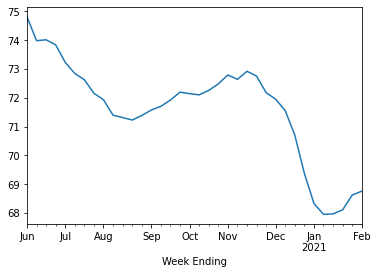

In [12]:
ca_occupied['Total Number of Occupied Beds'].plot(label = 'orig');

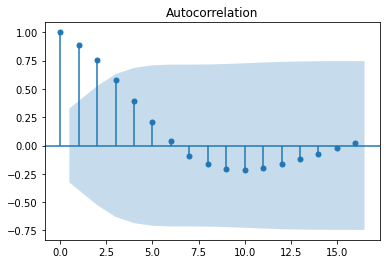

In [13]:
plot_acf(ca_occupied['Total Number of Occupied Beds']);

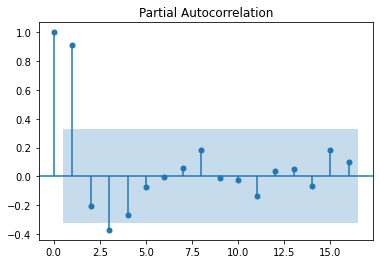

In [14]:
plot_pacf(ca_occupied['Total Number of Occupied Beds']);

In [15]:
interpret_dftest(ca_occupied)

best_col: diff2
best_p: 3.5415920390257884e-12


,column,Test Statistic,p-value,1 - p-value
0,Total Number of Occupied Beds,-1.191652,6.771766e-01,0.322823
1,diff1,-3.438465,9.715425e-03,0.990285
2,diff2,-7.929632,3.541592e-12,1.000000


In [16]:
y_train, y_test = train_test_split(ca_occupied['Total Number of Occupied Beds'],shuffle=False, test_size = .1)

*Note: The code in the two cells directly below, as well as all other iterations of it in this notebook, were adapted from the [7.07-lesson-arima-modeling repo](https://git.generalassemb.ly/DSIR-20201214-E/lesson-ARIMA), originally written by Matt Brems, Joseph Nelson and Justin Pounders.*

In [17]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0

# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0<= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    
            except:
                pass

print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)

best aic: 22.29160858299634
best p: 2
best d: 2
best q: 0


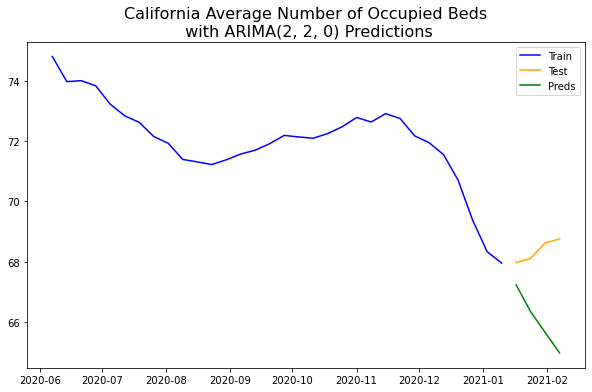

In [18]:
# Instantiate best model.
ca_occ_model = ARIMA(endog=y_train, order=(best_p, best_d, best_q))

# Fit ARIMA model.
arima = ca_occ_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start=y_test.index[0], end=y_test.index[-1])

# Plot data.
plt.figure(figsize=(10, 6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color='blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color='orange', label='Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color='green', label='Preds')

plt.title(
    label=f'California Average Number of Occupied Beds\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions',
    fontsize=16)
plt.legend()

plt.savefig('../assets/ca_avg_num_occupied_beds.png');

### 'Residents Weekly COVID-19 Deaths'

In [19]:
ca_weekly_deaths = ca_avgs[['Residents Weekly COVID-19 Deaths']].copy()

ca_weekly_deaths['diff1'] = ca_weekly_deaths['Residents Weekly COVID-19 Deaths'].diff()
ca_weekly_deaths['diff2'] = ca_weekly_deaths['Residents Weekly COVID-19 Deaths'].diff().diff()
ca_weekly_deaths.dropna(inplace = True)

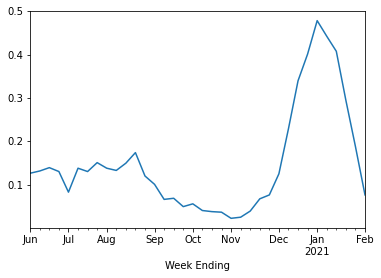

In [20]:
ca_weekly_deaths['Residents Weekly COVID-19 Deaths'].plot(label = 'orig');

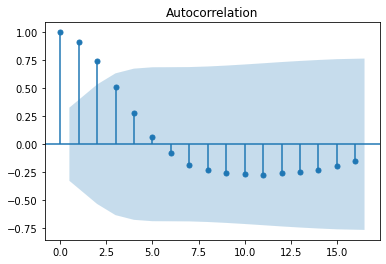

In [21]:
plot_acf(ca_weekly_deaths['Residents Weekly COVID-19 Deaths']);

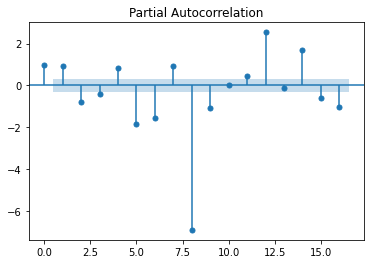

In [22]:
plot_pacf(ca_weekly_deaths['Residents Weekly COVID-19 Deaths']);

In [23]:
interpret_dftest(ca_weekly_deaths)

best_col: diff2
best_p: 4.094946591950674e-11


,column,Test Statistic,p-value,1 - p-value
0,Residents Weekly COVID-19 Deaths,-4.165176,7.542719e-04,0.999246
1,diff1,-3.173818,2.155112e-02,0.978449
2,diff2,-7.507616,4.094947e-11,1.000000


In [24]:
y_train, y_test = train_test_split(ca_weekly_deaths['Residents Weekly COVID-19 Deaths'],shuffle=False, test_size = .1)


In [25]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0
# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(4):
        
        # Insert try and except statements.
            try:

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if  abs(model.aic) < abs(best_aic):

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    

            except:
                pass
            
print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)


best aic: -43.008323710636674
best p: 0
best d: 0
best q: 0


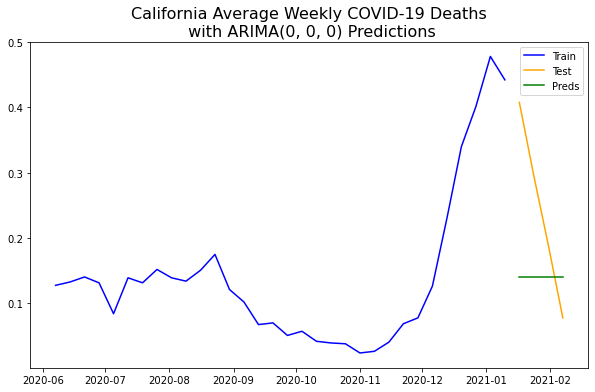

In [26]:
# Instantiate best model.
ca_week_deaths_model = ARIMA(endog = y_train, order = (best_p,best_d,best_q))

# Fit ARIMA model.
arima = ca_week_deaths_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0], end= y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'Preds')

plt.title(label = f'California Average Weekly COVID-19 Deaths\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions', fontsize=16)
plt.legend()

plt.savefig('../assets/ca_weekly_avg_num_covid_deaths.png');

### 'Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'

In [27]:
ca_weekly_confirmed_cases = ca_avgs[['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents']].copy()

ca_weekly_confirmed_cases['diff1'] = ca_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'].diff()
ca_weekly_confirmed_cases['diff2'] = ca_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'].diff().diff()
ca_weekly_confirmed_cases.dropna(inplace = True)

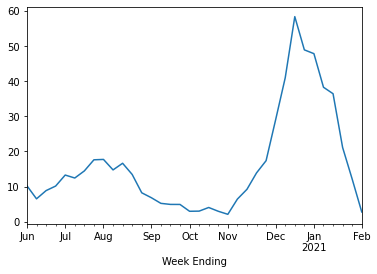

In [28]:
ca_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'].plot(label = 'orig');


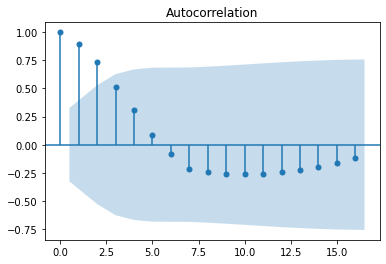

In [29]:
plot_acf(ca_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents']);

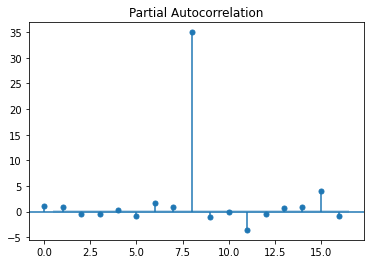

In [30]:
plot_pacf(ca_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents']);

In [31]:
interpret_dftest(ca_weekly_confirmed_cases)

best_col: diff2
best_p: 2.2706590547978155e-25


,column,Test Statistic,p-value,1 - p-value
0,Weekly Resident Confirmed COVID-19 Cases Per 1...,-3.356203,1.254566e-02,0.987454
1,diff1,-2.896684,4.573498e-02,0.954265
2,diff2,-13.565104,2.270659e-25,1.000000


In [32]:
y_train, y_test = train_test_split(ca_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'],shuffle=False, test_size = .1)

In [33]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0
# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0<= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    

            except:
                pass

print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)


best aic: 190.5787717614457
best p: 1
best d: 2
best q: 3


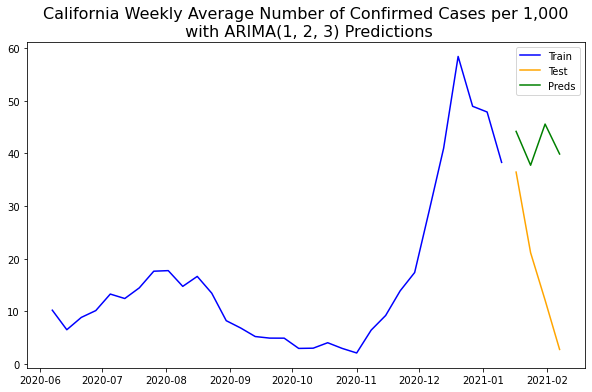

In [34]:
# Instantiate best model.
ca_week_conf_cases_per_thous_model = ARIMA(endog = y_train, order = (best_p,best_d,best_q))

# Fit ARIMA model.
arima = ca_week_conf_cases_per_thous_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0], end= y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'Preds')

plt.title(label = f'California Weekly Average Number of Confirmed Cases per 1,000\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions', fontsize=16)
plt.legend()

plt.savefig('../assets/ca_avg_num_confirmed_cases_per_thous.png');

### 'Weekly Resident COVID-19 Deaths Per 1,000 Residents'

In [35]:
ca_weekly_covid_deaths_per_thous = ca_avgs[['Weekly Resident COVID-19 Deaths Per 1,000 Residents']].copy()

ca_weekly_covid_deaths_per_thous['diff1'] = ca_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'].diff()
ca_weekly_covid_deaths_per_thous['diff2'] = ca_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'].diff().diff()
ca_weekly_covid_deaths_per_thous.dropna(inplace = True)

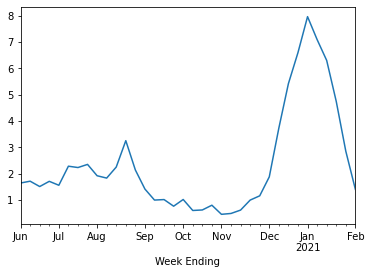

In [36]:
ca_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'].plot(label = 'orig');


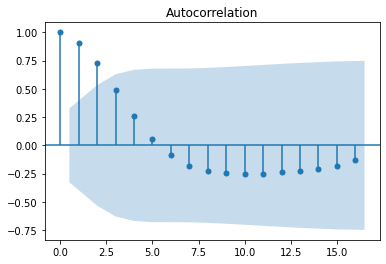

In [37]:
plot_acf(ca_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents']);

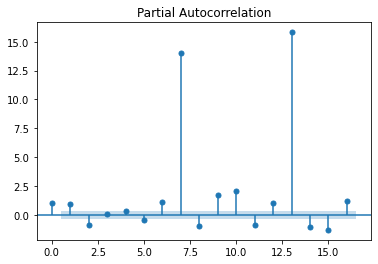

In [38]:
plot_pacf(ca_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents']);

In [39]:
interpret_dftest(ca_weekly_covid_deaths_per_thous)

best_col: diff2
best_p: 2.602439340155059e-29


,column,Test Statistic,p-value,1 - p-value
0,"Weekly Resident COVID-19 Deaths Per 1,000 Resi...",-3.302951,1.474706e-02,0.985253
1,diff1,-2.392741,1.437956e-01,0.856204
2,diff2,-16.407540,2.602439e-29,1.000000


In [40]:
y_train, y_test = train_test_split(ca_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'],shuffle=False, test_size = .1)


In [41]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0
# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0<= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    

            except:
                pass
print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)

best aic: 12.0
best p: 3
best d: 0
best q: 1


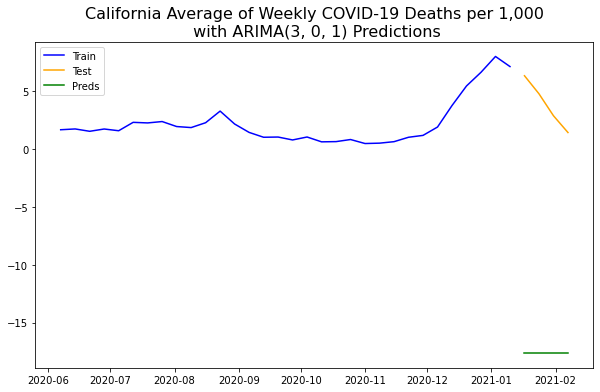

In [42]:
# Instantiate best model.
ca_weekly_deaths_per_thous_model = ARIMA(endog = y_train, order = (best_p,best_d,best_q))

# Fit ARIMA model.
arima = ca_weekly_deaths_per_thous_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0], end= y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'Preds')

plt.title(label = f'California Average of Weekly COVID-19 Deaths per 1,000\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions', fontsize=16)
plt.legend()

plt.savefig('../assets/ca_weekly_avg_covid_deaths_per_1000.png');